## Settings

In [4]:
import yfinance as yf, pandas as pd, numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

start, end = "1990-12-31", "2013-01-01"
tickers = ["^SP500TR", "VBMFX", "^SPGSCI", "^IRX"]
px = yf.download(tickers, start=start, end=end, interval="1mo")["Close"]

irx_yld = px["^IRX"].fillna(method="ffill") / 100
rf_tr   = (1 + irx_yld/12).cumprod()
rf_tr.name = "RF_TR"
lvl = pd.concat([px[["^SP500TR","VBMFX","^SPGSCI"]], rf_tr], axis=1)
lvl.columns = ["EQ","BD","CM","RF"]
lvl = lvl.ffill().dropna()

# monthly log-returns 1991-01 – 2012-12
ret_m = np.log(lvl).diff().loc["1991-01":"2012-12"].dropna()

# 4) annual arithmetic returns (calendar years)
ret_y = ret_m.resample("A").sum().apply(np.exp).sub(1)
ret_y.index = ret_y.index.year
sample = ret_y               # 22×4 matrix


[*********************100%***********************]  4 of 4 completed


In [5]:
g_m = 1 + ret_m

g_y = g_m.resample("A").prod()     # calendar years: 1991 … 2012

ret_y = g_y.sub(1)
ret_y.index = ret_y.index.year 
print(ret_y.shape)


(22, 4)


In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def make_lambda0(mu0: np.ndarray,
                 coverage: float = 0.90,
                 rho: float | None = None) -> np.ndarray:
    # 1) centre of the prior

    # 2) required z-score for lower tail (10 % if coverage=0.90)
    z_lower = norm.ppf(1 - coverage)       # e.g. 0.10 → –1.281552

    tau = (1 + mu0) / abs(z_lower)         # element-wise

    # 4) build Λ₀
    tau[3] = 0.001
    sigma = np.diag(tau)          # diagonal matrix


    Lambda0 = sigma @ rho @ sigma
    
    return mu0, Lambda0           # return μ₀ as well for convenience
mu0, Lambda0 =  make_lambda0(np.zeros(4), 
                  coverage=0.90, 
                  rho = np.array([[1, -0.3, 0.3, 0],
                                    [-0.3, 1, -0.3, 0],
                                    [0.3, -0.3, 1, 0],
                                    [0, 0, 0, 1]]))


In [7]:
nu0=6
S0=Lambda0

## Gibbs Sampling

In [8]:
from scipy.stats import invwishart, multivariate_normal
from tqdm import tqdm
S = 50_000
T = sample.shape[0]
Sigma = np.cov(sample.T)
def mu_sampling(T, Sigma):
    Lambda_T = np.linalg.inv(np.linalg.inv(Lambda0) + T*np.linalg.inv(Sigma))
    mu_T = Lambda_T @ (np.linalg.inv(Lambda0) @ mu0 + T*np.linalg.inv(Sigma) @ sample.mean())
    return multivariate_normal(mu_T, Lambda_T).rvs()

def Sigma_sampling(T, mu):
    nu_T = nu0 + T
    S_T = S0 + (sample - mu).T @ (sample - mu)
    return invwishart(nu_T, S_T).rvs()

mu_list = []
Sigma_list = []
for s in tqdm(range(S)):
    mu = mu_sampling(T, Sigma)
    Sigma = Sigma_sampling(T, mu)
    mu_list.append(mu)
    Sigma_list.append(Sigma)
mu_post_mean = np.mean(mu_list, axis=0)
Sigma_post_mean = np.mean(Sigma_list, axis=0)
mu_post_mean.round(3), Sigma_post_mean.round(3)

100%|██████████| 50000/50000 [00:48<00:00, 1029.63it/s]


(array([0.038, 0.048, 0.113, 0.001]),
 array([[ 0.07 , -0.006,  0.015,  0.003],
        [-0.006,  0.033, -0.012,  0.001],
        [ 0.015, -0.012,  0.099, -0.001],
        [ 0.003,  0.001, -0.001,  0.001]]))

In [9]:
# drawing shrinkage
burn = 49_000
mu_target = np.mean(mu_list[burn:], axis=0)
sigma_target = np.mean(Sigma_list[burn:], axis=0)
shrinkage_mu = []
shrinkage_Sigma = []
for s in range(S):
    norm_mu = (mu_target - mu_list[s]) @ (mu_target - mu_list[s])
    shrinkage_mu.append(norm_mu)
    norm_Sigma = np.linalg.norm(sigma_target - Sigma_list[s])
    shrinkage_Sigma.append(norm_Sigma)

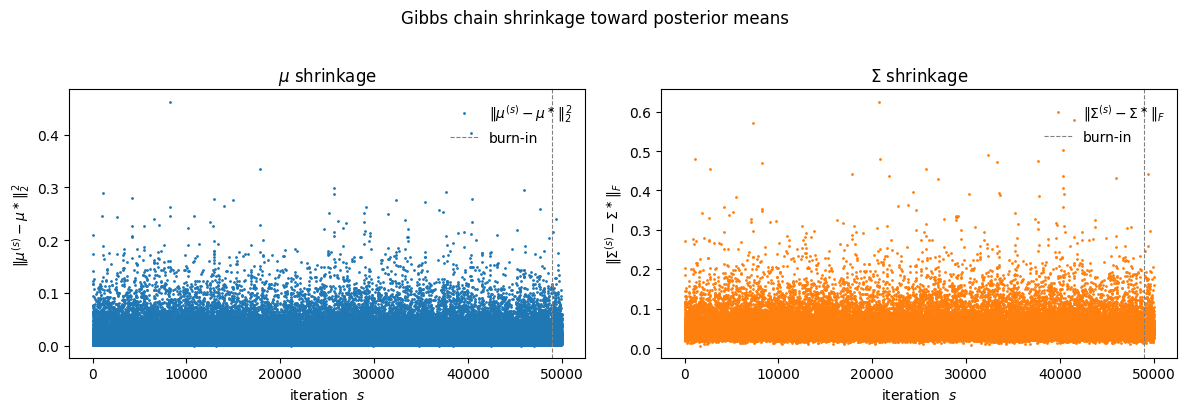

In [10]:
import matplotlib.pyplot as plt
import numpy as np

iters = np.arange(S)                 # 0 … S-1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# ── μ-shrinkage (left) ──────────────────────────────────────────
ax1.plot(iters, shrinkage_mu, ls="None", marker=".", ms=2,
         color="tab:blue", label=r"$\|\mu^{(s)}-\mu^\ast\|_2^{\,2}$")
ax1.axvline(burn, color="grey", ls="--", lw=0.8, label="burn-in")
ax1.set_xlabel("iteration  $s$")
ax1.set_ylabel(r"$\|\mu^{(s)}-\mu^\ast\|_2^{\,2}$")
ax1.set_title(r"$\mu$ shrinkage")
ax1.legend(loc="upper right", frameon=False)

# ── Σ-shrinkage (right) ─────────────────────────────────────────
ax2.plot(iters, shrinkage_Sigma, ls="None", marker=".", ms=2,
         color="tab:orange", label=r"$\|\Sigma^{(s)}-\Sigma^\ast\|_F$")
ax2.axvline(burn, color="grey", ls="--", lw=0.8, label="burn-in")
ax2.set_xlabel("iteration  $s$")
ax2.set_ylabel(r"$\|\Sigma^{(s)}-\Sigma^\ast\|_F$")
ax2.set_title(r"$\Sigma$ shrinkage")
ax2.legend(loc="upper right", frameon=False)

fig.suptitle("Gibbs chain shrinkage toward posterior means", y=1.02)
fig.tight_layout()
plt.show()


In [ ]:
import numpy as np
import arviz as az

mu_arr    = np.array(mu_list)        # shape (N, 4)
Sigma_arr = np.array(Sigma_list)     # shape (N, 4, 4)

n_total   = mu_arr.shape[0]
n_chain   = 4
draws     = n_total // n_chain
mu_split  = mu_arr[:draws*n_chain].reshape(n_chain, draws, 4)
Sigma_split = Sigma_arr[:draws*n_chain].reshape(n_chain, draws, 4, 4)

idata = az.from_dict(posterior={
    "mu":    mu_split,           # (chain, draw, dim)
    "Sigma": Sigma_split         # (chain, draw, row, col)
})

print("R-hat (bulk):")
print(az.rhat(idata, var_names=["mu","Sigma"]))

print("\nESS  (bulk):")
print(az.ess(idata, method="bulk", var_names=["mu","Sigma"]))

print("\nESS  (tail):")
print(az.ess(idata, method="tail", var_names=["mu","Sigma"]))


R-hat (bulk):
<xarray.Dataset> Size: 256B
Dimensions:      (mu_dim_0: 4, Sigma_dim_0: 4, Sigma_dim_1: 4)
Coordinates:
  * mu_dim_0     (mu_dim_0) int64 32B 0 1 2 3
  * Sigma_dim_0  (Sigma_dim_0) int64 32B 0 1 2 3
  * Sigma_dim_1  (Sigma_dim_1) int64 32B 0 1 2 3
Data variables:
    mu           (mu_dim_0) float64 32B 1.0 1.0 1.001 1.0
    Sigma        (Sigma_dim_0, Sigma_dim_1) float64 128B 1.0 1.0 ... 1.001 1.0

ESS  (bulk):
<xarray.Dataset> Size: 256B
Dimensions:      (mu_dim_0: 4, Sigma_dim_0: 4, Sigma_dim_1: 4)
Coordinates:
  * mu_dim_0     (mu_dim_0) int64 32B 0 1 2 3
  * Sigma_dim_0  (Sigma_dim_0) int64 32B 0 1 2 3
  * Sigma_dim_1  (Sigma_dim_1) int64 32B 0 1 2 3
Data variables:
    mu           (mu_dim_0) float64 32B 8.529e+03 8.319e+03 8.746e+03 4.798e+04
    Sigma        (Sigma_dim_0, Sigma_dim_1) float64 128B 1.974e+04 ... 4.765e+04

ESS  (tail):
<xarray.Dataset> Size: 256B
Dimensions:      (mu_dim_0: 4, Sigma_dim_0: 4, Sigma_dim_1: 4)
Coordinates:
  * mu_dim_0     (mu_dim_0) 

In [12]:
print(mu_target.round(3))
print(sigma_target.round(3))

[0.047 0.042 0.116 0.001]
[[ 0.069 -0.006  0.015  0.002]
 [-0.006  0.033 -0.013  0.001]
 [ 0.015 -0.013  0.1   -0.001]
 [ 0.002  0.001 -0.001  0.001]]


In [13]:
C = np.array([[0.0, 0.0, 0.0, 0.0] for _ in range(4)])
a = np.array([0.0, 0.0, 0.0, 0.0])
for i in range(4):
    for j in range(4):
        C[i][j] = (1+mu_target[i]+mu_target[j]+sigma_target[i][j] + mu_target[i]*mu_target[j])**len(sample)
    a[i] = (1+mu_target[i])**len(sample)


In [14]:
np.set_printoptions(precision=3, suppress=True)
K = C-np.outer(a, a)
print((K).round(3))
print(np.linalg.eig(K)[0])

[[ 21.865  -0.756   9.657   0.149]
 [ -0.756   5.547  -5.835   0.053]
 [  9.657  -5.835 560.613  -0.276]
 [  0.149   0.053  -0.276   0.029]]
[560.847  21.72    5.46    0.027]


## Drawing Efficient Frontiers

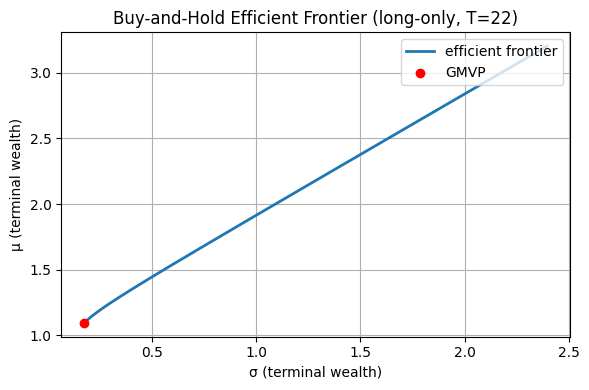

In [ ]:
import numpy as np, matplotlib.pyplot as plt

mu_hat = np.array([0.038, 0.050, 0.113, 0.001])
Sigma  = np.array([[ 0.070,-0.007, 0.015, 0.003],
                   [-0.007, 0.033,-0.012, 0.001],
                   [ 0.015,-0.012, 0.098,-0.001],
                   [ 0.003, 0.001,-0.001, 0.001]])
T = 22

b = 1 + mu_hat
a = b**T
B = (b[:,None]*b[None,:] + Sigma)
C = B**T
K = C - np.outer(a,a)           # (4,4)

one = np.ones(4)

def get_sigma(mu_p):
    Ap = np.block([
        [np.r_[one, 0, 0][None,:]],
        [np.r_[a,   0, 0][None,:]],
        [np.c_[K, -one[:,None], -a[:,None]]]
    ])
    Cp = np.r_[1, mu_p, 0, 0, 0, 0]
    try:
        x = np.linalg.solve(Ap, Cp)
    except np.linalg.LinAlgError:
        return None
    w = x[:4]
    if (w < 0).any():           # long-only
        return None
    return np.sqrt(w @ K @ w)

mu_min, mu_max = a.min()-1, a.max()-1
grid = np.linspace(mu_min, mu_max, 800)

sig, mu = [], []
for m in grid:
    s = get_sigma(m)
    if s is not None:
        sig.append(s)
        mu.append(m)

sig, mu = np.array(sig), np.array(mu)

plt.figure(figsize=(6,4))
plt.plot(sig, mu, lw=2)
plt.scatter(sig[sig.argmin()], mu[sig.argmin()], color='red', zorder=5)
plt.xlabel("σ (terminal wealth)")
plt.ylabel("μ (terminal wealth)")
plt.title("Buy-and-Hold Efficient Frontier (long-only, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("q1no_shorting.png", dpi=300)
plt.show()


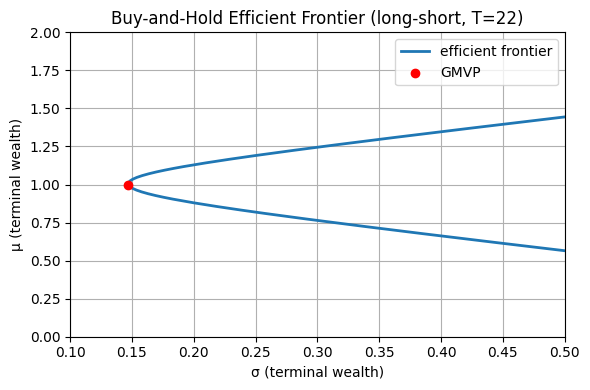

In [ ]:
# shorting is allowed
import numpy as np, matplotlib.pyplot as plt

mu_hat = np.array([0.038, 0.050, 0.113, 0.001])
Sigma  = np.array([[ 0.070,-0.007, 0.015, 0.003],
                   [-0.007, 0.033,-0.012, 0.001],
                   [ 0.015,-0.012, 0.098,-0.001],
                   [ 0.003, 0.001,-0.001, 0.001]])
T = 22

b = 1 + mu_hat
a = b**T
B = (b[:,None]*b[None,:] + Sigma)
C = B**T
K = C - np.outer(a,a)           # (4,4)

one = np.ones(4)

def get_sigma(mu_p):
    Ap = np.block([
        [np.r_[one, 0, 0][None,:]],
        [np.r_[a,   0, 0][None,:]],
        [np.c_[K, -one[:,None], -a[:,None]]]
    ])
    Cp = np.r_[1, mu_p, 0, 0, 0, 0]
    try:
        x = np.linalg.solve(Ap, Cp)
    except np.linalg.LinAlgError:
        return None
    w = x[:4]
    return np.sqrt(w @ K @ w)

mu_min, mu_max = a.min()-1, a.max()-1
grid = np.linspace(mu_min, mu_max, 800)

sig, mu = [], []
for m in grid:
    s = get_sigma(m)
    if s is not None:
        sig.append(s)
        mu.append(m)

sig, mu = np.array(sig), np.array(mu)

plt.figure(figsize=(6,4))
plt.plot(sig, mu, lw=2)
plt.xlim(0.1, 0.5)
plt.ylim(0, 2)
plt.scatter(sig[sig.argmin()], mu[sig.argmin()], color='red', zorder=5)
plt.xlabel("σ (terminal wealth)")
plt.ylabel("μ (terminal wealth)")
plt.title("Buy-and-Hold Efficient Frontier (long-short, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("q1shorting.png", dpi=300)
plt.show()


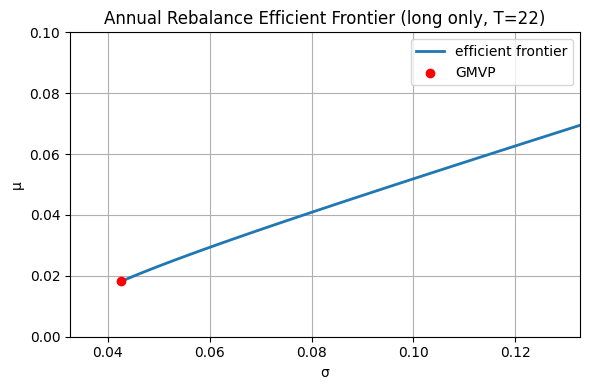

In [ ]:
# Q2 drawing, no shorting
import numpy as np, matplotlib.pyplot as plt

mu_hat = np.array([0.038, 0.050, 0.113, 0.001])
Sigma  = np.array([[ 0.070,-0.007, 0.015, 0.003],
                   [-0.007, 0.033,-0.012, 0.001],
                   [ 0.015,-0.012, 0.098,-0.001],
                   [ 0.003, 0.001,-0.001, 0.001]])

one = np.ones(4)

def get_sigma(mu_p):
    Ap = np.block([
        [np.r_[one, 0, 0][None,:]],
        [np.r_[mu_hat,   0, 0][None,:]],
        [np.c_[Sigma, -one[:,None], -mu_hat[:,None]]]
    ])
    Cp = np.r_[1, mu_p, 0, 0, 0, 0]
    try:
        x = np.linalg.solve(Ap, Cp)
    except np.linalg.LinAlgError:
        return None
    w = x[:4]
    if (w < 0).any():           # long-only
        return None
    return np.sqrt(w @ Sigma @ w)

grid = np.linspace(-0.5, 0.5, 800)

sig, mu = [], []
for m in grid:
    s = get_sigma(m)
    if s is not None:
        sig.append(s)
        mu.append(m)

sig, mu = np.array(sig), np.array(mu)
sig_min, sig_max = sig.min(), sig.max()

plt.figure(figsize=(6,4))
plt.plot(sig, mu, lw=2)
plt.xlim(sig_min-0.01, sig_max)
plt.ylim(0, grid.max()-0.4)
plt.scatter(sig[sig.argmin()], mu[sig.argmin()], color='red', zorder=5)
plt.xlabel("σ")
plt.ylabel("μ")
plt.title("Annual Rebalance Efficient Frontier (long only, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("q2no_shorting.png", dpi=300)
plt.show()


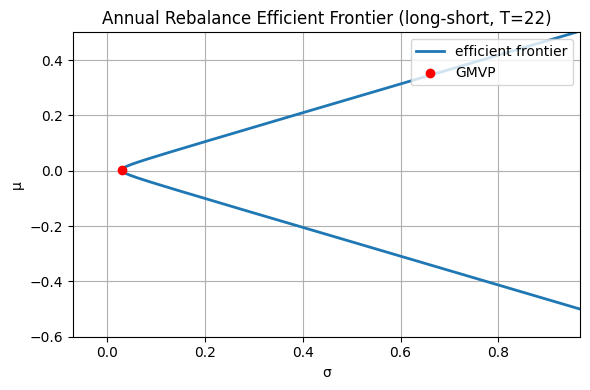

In [ ]:
# Q2 drawing, shorting
import numpy as np, matplotlib.pyplot as plt

mu_hat = np.array([0.038, 0.050, 0.113, 0.001])
Sigma  = np.array([[ 0.070,-0.007, 0.015, 0.003],
                   [-0.007, 0.033,-0.012, 0.001],
                   [ 0.015,-0.012, 0.098,-0.001],
                   [ 0.003, 0.001,-0.001, 0.001]])

one = np.ones(4)

def get_sigma(mu_p):
    Ap = np.block([
        [np.r_[one, 0, 0][None,:]],
        [np.r_[mu_hat,   0, 0][None,:]],
        [np.c_[Sigma, -one[:,None], -mu_hat[:,None]]]
    ])
    Cp = np.r_[1, mu_p, 0, 0, 0, 0]
    try:
        x = np.linalg.solve(Ap, Cp)
    except np.linalg.LinAlgError:
        return None
    w = x[:4]
    return np.sqrt(w @ Sigma @ w)

grid = np.linspace(-0.5, 0.5, 800)

sig, mu = [], []
for m in grid:
    s = get_sigma(m)
    if s is not None:
        sig.append(s)
        mu.append(m)

sig, mu = np.array(sig), np.array(mu)
sig_min, sig_max = sig.min(), sig.max()

plt.figure(figsize=(6,4))
plt.plot(sig, mu, lw=2)
plt.xlim(sig_min-0.1, sig_max)
plt.ylim(grid.min()-0.1, grid.max())
plt.scatter(sig[sig.argmin()], mu[sig.argmin()], color='red', zorder=5)
plt.xlabel("σ")
plt.ylabel("μ")
plt.title("Annual Rebalance Efficient Frontier (long-short, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("q2shorting.png", dpi=300)
plt.show()
